In [152]:
import os
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
import math

In [ ]:
# 7 Assets (Nvidia, Ford, Lucid Group, Palantir Tech., Microsoft Corp., American Airlines, Tesla Inc)
tickers = ['NVDA', 'F', 'LCID', 'PLTR', 'MSFT','AAL', 'TSLA']

tickers = [ticker.upper() for ticker in tickers]  # alphabetizes the stocks in dataframe

# Gathers asset's data from past 2 years (730 days) to today
start_date = dt.datetime.today() - pd.Timedelta(730, "d")
end_date = dt.datetime.today()

# Downloads stock data
tickers_data = yf.download(start=start_date, end=end_date, tickers=tickers, auto_adjust=False)['Adj Close']
tickers_data.head()


[*********************100%***********************]  7 of 7 completed


Ticker,AAL,F,LCID,MSFT,NVDA,PLTR,TSLA
Date,,,,,,,
2023-04-25,12.84,10.375512,6.74,271.108154,26.223969,7.74,160.669998
2023-04-26,12.74,10.172762,7.22,290.745789,26.938503,7.74,153.750000
2023-04-27,12.88,10.234469,8.17,300.057709,27.208332,7.82,160.190002
2023-04-28,13.64,10.472480,7.94,302.449646,27.730991,7.75,164.309998
2023-05-01,13.89,10.631154,7.32,300.776276,28.891237,7.78,161.830002


In [154]:
daily_returns = tickers_data.pct_change()

# Asset's mean
mean_returns = daily_returns.mean()

# Asset's variance
variance = daily_returns.var()

/var/folders/q9/1h42_3tn705_j_750qfm6dz00000gn/T/ipykernel_33120/2935501833.py:1: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  daily_returns = tickers_data.pct_change()


<Axes: xlabel='Ticker', ylabel='Ticker'>

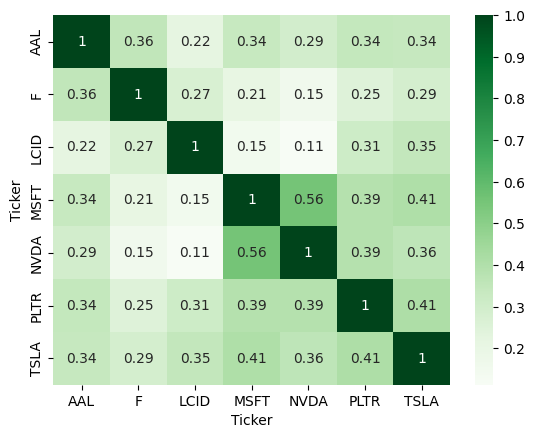

In [155]:
# Correlation matrix
corMatrix = daily_returns.corr()
sns.heatmap(corMatrix, cmap= 'Greens', annot= True)

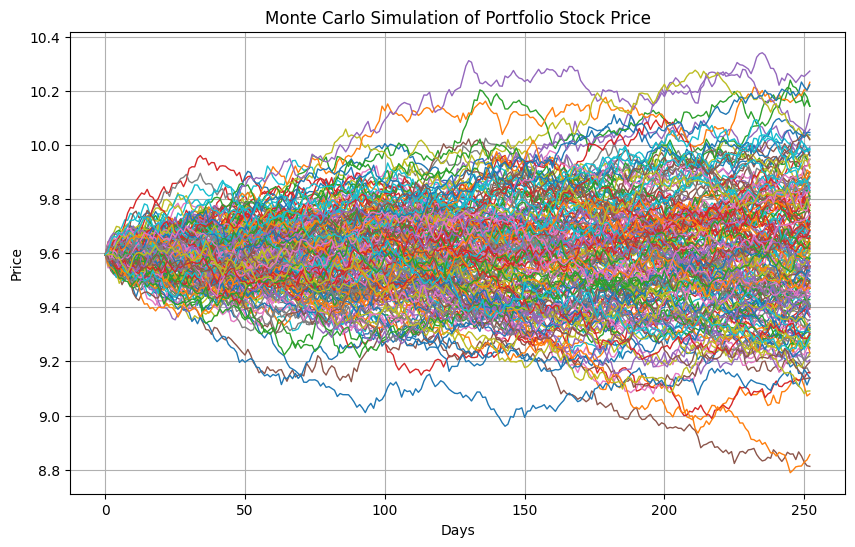

In [ ]:
#--------------------------------Monte Carlo simulation------------------------------------

#Constants
T= 1.0  #Time horizons (1yr)
M = 252  # Num of Days)
I = 80000  # Num of simulated paths (to optimize portofolio, 80k-100k path is recommended)

#Used numpy version of monte carlo simulation, due to it's speed. 
def mcs_simulation_np(p):
    M, I = p
    dt = T / M
    S0 = tickers_data.iloc[-1].values  # Latest stock prices 
    S = np.zeros((M + 1, I, len(tickers)))  # Adjust the shape of S
    S[0] = S0
    rn = np.random.standard_normal(S.shape)
    for t in range(1, M + 1):
        S[t] = S[t - 1] * np.exp((mean_returns.values - 0.5 * variance.values) * dt +
                                  np.sqrt(variance.values * dt) * rn[t])
    return S

S = mcs_simulation_np((M, I)) #runs simulation

stock_index = 0  
num_paths = 200   # Number of simulated paths to plot

plt.figure(figsize=(10, 6))
for i in range(num_paths):
    plt.plot(S[:, i, stock_index], lw=1)

plt.title(f"Monte Carlo Simulation of Portfolio Stock Price")
plt.xlabel("Days")
plt.ylabel("Price")
plt.grid(True)
plt.show()

In [ ]:
# ------------------Calculates portfolio returns and volatilities 
def portfolio_returns(weights):
    return np.sum(daily_returns.mean() * weights) * 252
def portfolio_volatilities(weights):
    return np.sqrt(np.dot(weights.T, np.dot(daily_returns.cov() * 252, weights)))

p_returns =[]
p_volatilities = []

for i in range(I):
    weights = np.random.random(len(tickers))
    weights /= np.sum(weights)  # Normalize weights to sum up to 1
    p_returns.append(portfolio_returns(weights))
    p_volatilities.append(portfolio_volatilities(weights))
    
p_returns = np.array(p_returns)
p_volatilities=np.array(p_volatilities)

In [158]:
#---------------------------Optimal Portfolio
import scipy.optimize as sco
def min_func_sharpe(weights):
    return -portfolio_returns(weights)/portfolio_volatilities(weights) # Min negative Sharpe ratio

cons= ({'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in range(len(tickers)))
eweights = np.array(len(tickers) * [1. / len(tickers),])

# Maximization of the Sharpe ratio
opts = sco.minimize(min_func_sharpe, eweights,method='SLSQP', bounds= bnds,constraints= cons)

optimal_port_weight= opts['x'].round(3) #sum of weights must = 1!
print("Optimal portfolio weights:", optimal_port_weight)
optimal_returns = portfolio_returns(opts['x']).round(3)
optimal_volatility = portfolio_volatilities(opts['x']).round(3)
opt_sharpe_ratio = optimal_returns / optimal_volatility

print('Optimal Sharpe ratio:', opt_sharpe_ratio)


Optimal portfolio weights: [0.    0.    0.    0.    0.354 0.646 0.   ]
Optimal Sharpe ratio: 2.313274336283186


In [159]:
# Minimization of the variance
optv = sco.minimize(portfolio_volatilities, eweights, method='SLSQP', bounds=bnds, constraints=cons)
optv['x'].round(3)
portfolio_volatilities(optv['x']).round(3)
portfolio_returns(optv['x']).round(3)
portfolio_returns(optv['x']) / portfolio_volatilities(optv['x'])

0.7406082640671895

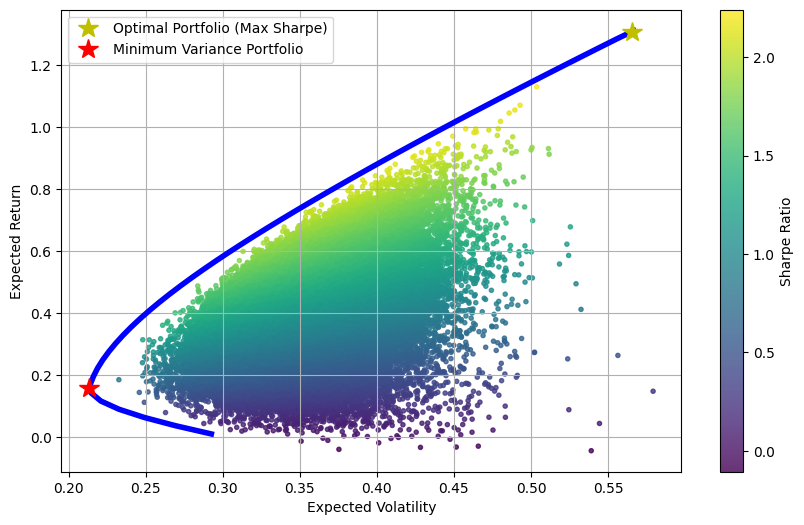

In [163]:
#----------------Efficient Frontier ---------------

cons = ({'type': 'eq', 'fun': lambda x: portfolio_returns(x) - tret}, {'type': 'eq', 'fun': lambda x: np.sum(x) - 1})
bnds = tuple((0, 1) for x in weights)
    
#tret=Returns, tvols=Volatility

trets = np.linspace(0.01, 1.31, 50) #target returns level (y-axix of the blue curve)
tvols = []

# minimization loop of the volatilities
for tret in trets:
    res = sco.minimize(portfolio_volatilities, eweights, method='SLSQP', bounds=bnds, constraints=cons)
    tvols.append(res['fun'])
tvols = np.array(tvols)

#Plot
plt.figure(figsize=(10, 6))
plt.scatter(p_volatilities, p_returns, c= p_returns / p_volatilities, marker='.', alpha=0.8, cmap='viridis')
plt.plot(tvols, trets, 'b', lw=4.0)
plt.plot(portfolio_volatilities(opts['x']), portfolio_returns(opts['x']),'y*', markersize=15.0,label='Optimal Portfolio (Max Sharpe)' )
plt.plot(portfolio_volatilities(optv['x']), portfolio_returns(optv['x']), 'r*', markersize=15.0, label='Minimum Variance Portfolio')
plt.xlabel('Expected Volatility')
plt.ylabel('Expected Return')
plt.legend(loc='best')
plt.grid(True)
plt.colorbar(label='Sharpe Ratio')
